In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from sklearn.metrics import r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("📊 OVERFITTING & LEARNING CURVE ANALYSIS")
print("=" * 70)

📊 OVERFITTING & LEARNING CURVE ANALYSIS


In [2]:
# Load the pre-processed data
print("📈 Loading pre-processed data...")

# Load from your previous variables or recreate them
model_df = pd.read_csv("../data/processed/processed_weekly_modeling.csv")
ref_df = pd.read_csv("../data/processed/processed_weekly_reference.csv")

target_name = 'Target_1w_Price'
feature_cols = [col for col in model_df.columns if not col.startswith('Target_')]

X = model_df[feature_cols].copy()
y = model_df[target_name].copy()

train_mask = ref_df['Is_Train'].values
X_train, X_test = X[train_mask].copy(), X[~train_mask].copy()
y_train, y_test = y[train_mask].copy(), y[~train_mask].copy()

# Clean and scale (same as before)
from sklearn.preprocessing import StandardScaler, LabelEncoder

for col in feature_cols:
    try:
        X_train[col] = pd.to_numeric(X_train[col])
        X_test[col] = pd.to_numeric(X_test[col])
    except:
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Data loaded:")
print(f"   Train: {X_train_scaled.shape[0]} samples, {X_train_scaled.shape[1]} features")
print(f"   Test: {X_test_scaled.shape[0]} samples")
print(f"   Target range: [{y.min():.2f}, {y.max():.2f}]")

# Load all 6 models
models = {}
model_names = []

# Default models
default_dir = "../models/normalmodels"
for model_name, file_name in [('XGBoost Default', 'xgboost_model.pkl'),
                              ('LightGBM Default', 'lightgbm_model.pkl'),
                              ('CatBoost Default', 'catboost_model.pkl')]:
    try:
        with open(os.path.join(default_dir, file_name), 'rb') as f:
            models[model_name] = pickle.load(f)
            model_names.append(model_name)
            print(f"✅ Loaded: {model_name}")
    except:
        print(f"❌ Could not load: {model_name}")

# Tuned models
tuned_dir = "../models/tunedmodels/"
for model_name, file_name in [('XGBoost Tuned', 'xgboost_tuned.pkl'),
                              ('LightGBM Tuned', 'lightgbm_tuned.pkl'),
                              ('CatBoost Tuned', 'catboost_tuned.pkl')]:
    try:
        with open(os.path.join(tuned_dir, file_name), 'rb') as f:
            models[model_name] = pickle.load(f)
            model_names.append(model_name)
            print(f"✅ Loaded: {model_name}")
    except:
        print(f"❌ Could not load: {model_name}")

print(f"\n📋 Total models loaded: {len(models)}")

📈 Loading pre-processed data...
✅ Data loaded:
   Train: 4080 samples, 64 features
   Test: 948 samples
   Target range: [62.80, 218.97]
✅ Loaded: XGBoost Default
✅ Loaded: LightGBM Default
✅ Loaded: CatBoost Default
✅ Loaded: XGBoost Tuned
✅ Loaded: LightGBM Tuned
✅ Loaded: CatBoost Tuned

📋 Total models loaded: 6



🔍 SIMPLE OVERFITTING DETECTION

📊 OVERFITTING ANALYSIS (Sorted by R² Gap):
--------------------------------------------------------------------------------
           Model  Train_R2  Test_R2   R2_Gap  Test_MAE
CatBoost Default  0.989869 0.943738 0.046131  4.177196
  CatBoost Tuned  0.993372 0.937436 0.055936  4.145567
  LightGBM Tuned  0.991673 0.917523 0.074150  4.535157
LightGBM Default  0.994509 0.918945 0.075565  4.449723
 XGBoost Default  0.997188 0.904927 0.092260  4.504353
   XGBoost Tuned  0.997699 0.889382 0.108318  4.786503


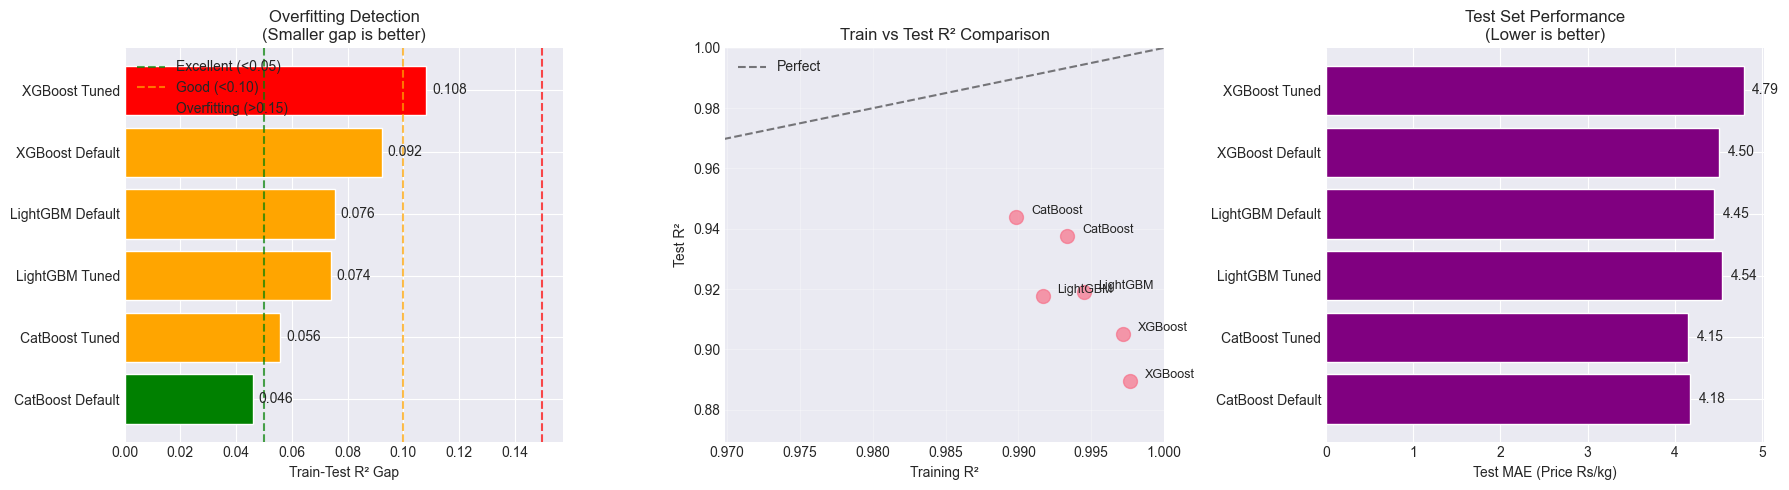

In [3]:
print("\n" + "="*70)
print("🔍 SIMPLE OVERFITTING DETECTION")
print("="*70)

# Calculate basic overfitting metrics
overfitting_data = []

for name, model in models.items():
    # Predictions
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)

    # R² scores
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    r2_gap = train_r2 - test_r2

    # MAE scores
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    mae_gap = train_mae - test_mae  # Usually negative

    overfitting_data.append({
        'Model': name,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'R2_Gap': r2_gap,
        'Train_MAE': train_mae,
        'Test_MAE': test_mae,
        'MAE_Gap': mae_gap
    })

# Create DataFrame
overfit_df = pd.DataFrame(overfitting_data).sort_values('R2_Gap')
print("\n📊 OVERFITTING ANALYSIS (Sorted by R² Gap):")
print("-" * 80)
print(overfit_df[['Model', 'Train_R2', 'Test_R2', 'R2_Gap', 'Test_MAE']].to_string(index=False))

# Visualize overfitting
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. R² Gap comparison
colors = ['green' if x < 0.05 else 'orange' if x < 0.10 else 'red' for x in overfit_df['R2_Gap']]
axes[0].barh(range(len(overfit_df)), overfit_df['R2_Gap'], color=colors)
axes[0].set_yticks(range(len(overfit_df)))
axes[0].set_yticklabels(overfit_df['Model'])
axes[0].set_xlabel('Train-Test R² Gap')
axes[0].set_title('Overfitting Detection\n(Smaller gap is better)')
axes[0].axvline(x=0.05, color='green', linestyle='--', alpha=0.7, label='Excellent (<0.05)')
axes[0].axvline(x=0.10, color='orange', linestyle='--', alpha=0.7, label='Good (<0.10)')
axes[0].axvline(x=0.15, color='red', linestyle='--', alpha=0.7, label='Overfitting (>0.15)')
axes[0].legend()

for i, v in enumerate(overfit_df['R2_Gap']):
    axes[0].text(v + 0.002, i, f'{v:.3f}', va='center')

# 2. Train vs Test R² scatter
axes[1].scatter(overfit_df['Train_R2'], overfit_df['Test_R2'], s=100, alpha=0.7)
for i, row in overfit_df.iterrows():
    axes[1].text(row['Train_R2'] + 0.001, row['Test_R2'] + 0.001,
                row['Model'].split()[0], fontsize=9)

axes[1].plot([0.7, 1.0], [0.7, 1.0], 'k--', alpha=0.5, label='Perfect')
axes[1].set_xlabel('Training R²')
axes[1].set_ylabel('Test R²')
axes[1].set_title('Train vs Test R² Comparison')
axes[1].set_xlim([overfit_df['Train_R2'].min() - 0.02, 1.0])
axes[1].set_ylim([overfit_df['Test_R2'].min() - 0.02, 1.0])
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Test MAE comparison
axes[2].barh(range(len(overfit_df)), overfit_df['Test_MAE'], color='purple')
axes[2].set_yticks(range(len(overfit_df)))
axes[2].set_yticklabels(overfit_df['Model'])
axes[2].set_xlabel('Test MAE (Price Rs/kg)')
axes[2].set_title('Test Set Performance\n(Lower is better)')

for i, v in enumerate(overfit_df['Test_MAE']):
    axes[2].text(v + 0.1, i, f'{v:.2f}', va='center')

plt.tight_layout()
plt.show()


📚 LEARNING CURVES FOR ALL MODELS
Creating learning curve for: XGBoost Default
Creating learning curve for: LightGBM Default
Creating learning curve for: CatBoost Default
Creating learning curve for: XGBoost Tuned
Creating learning curve for: LightGBM Tuned
Creating learning curve for: CatBoost Tuned


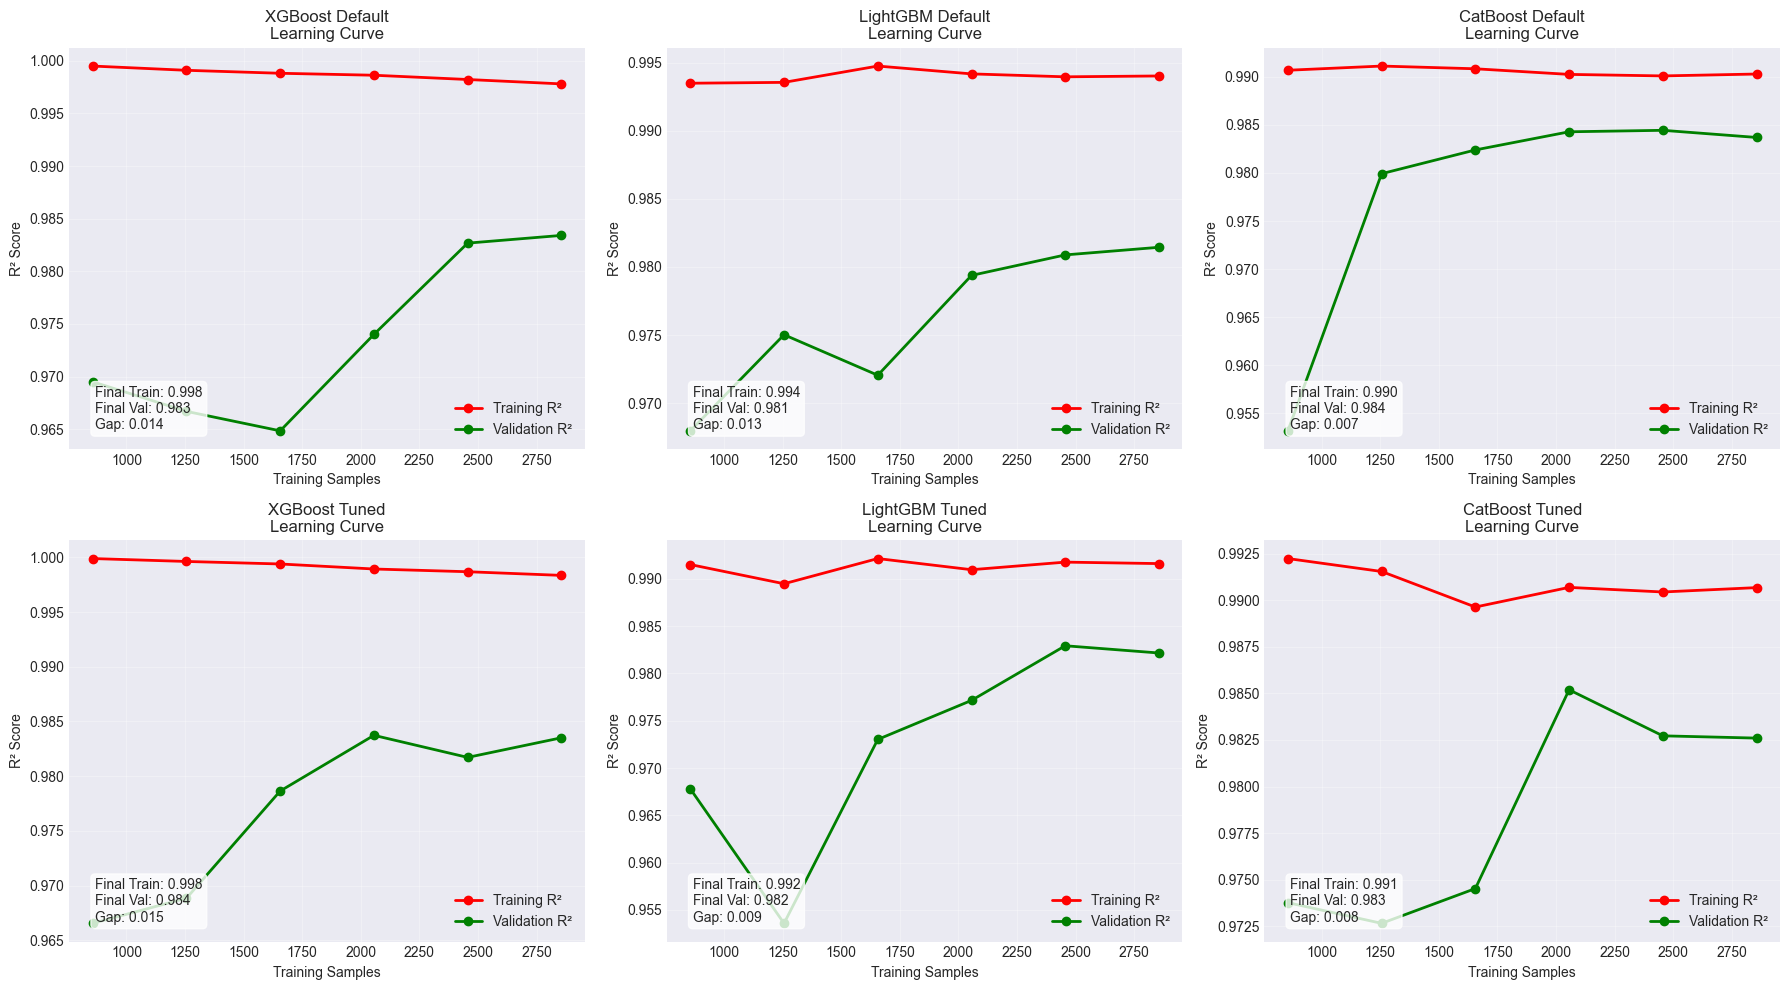

In [4]:
print("\n" + "="*70)
print("📚 LEARNING CURVES FOR ALL MODELS")
print("="*70)

def create_simple_learning_curve(model, X_train, y_train, n_points=6):
    """
    Create simple learning curves without sklearn compatibility issues
    """
    train_scores = []
    val_scores = []
    train_sizes = []

    total_samples = len(X_train)

    # Create training sizes (ensuring minimum samples)
    fractions = np.linspace(0.3, 1.0, n_points)

    for fraction in fractions:
        train_size = int(fraction * total_samples * 0.7)  # 70% of fraction for training
        val_size = int(total_samples * 0.3)  # Fixed 30% for validation

        # Ensure we have enough samples
        if train_size < 50 or val_size < 20:
            continue

        # Random indices
        indices = np.random.permutation(total_samples)
        train_idx = indices[:train_size]
        val_idx = indices[train_size:train_size + val_size]

        # Get data for this fold
        X_train_fold = X_train[train_idx]
        y_train_fold = y_train.iloc[train_idx]
        X_val_fold = X_train[val_idx]
        y_val_fold = y_train.iloc[val_idx]

        # Clone model
        import copy
        try:
            fold_model = copy.deepcopy(model)
            # Reset model if it has fit method
            if hasattr(fold_model, 'fit'):
                # For CatBoost, we need to create new instance
                if 'CatBoost' in str(type(fold_model)):
                    from catboost import CatBoostRegressor
                    fold_model = CatBoostRegressor(
                        iterations=100,
                        depth=6,
                        learning_rate=0.1,
                        random_seed=42,
                        verbose=False
                    )
        except:
            # If deepcopy fails, create new instance with same parameters
            if 'XGBoost' in str(type(model)):
                import xgboost as xgb
                fold_model = xgb.XGBRegressor(n_estimators=100, max_depth=6, random_state=42)
            elif 'LightGBM' in str(type(model)):
                import lightgbm as lgb
                fold_model = lgb.LGBMRegressor(n_estimators=100, max_depth=6, random_state=42, verbose=-1)
            else:
                continue

        # Train and predict
        fold_model.fit(X_train_fold, y_train_fold)

        y_train_pred = fold_model.predict(X_train_fold)
        y_val_pred = fold_model.predict(X_val_fold)

        train_score = r2_score(y_train_fold, y_train_pred)
        val_score = r2_score(y_val_fold, y_val_pred)

        train_scores.append(train_score)
        val_scores.append(val_score)
        train_sizes.append(train_size)

    return np.array(train_sizes), np.array(train_scores), np.array(val_scores)

# Create learning curves for all models
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

learning_curve_data = {}

for idx, (name, model) in enumerate(models.items()):
    if idx >= 6:
        break

    print(f"Creating learning curve for: {name}")

    try:
        # Get learning curve data
        train_sizes, train_scores, val_scores = create_simple_learning_curve(
            model, X_train_scaled, y_train
        )

        learning_curve_data[name] = {
            'train_sizes': train_sizes,
            'train_scores': train_scores,
            'val_scores': val_scores
        }

        ax = axes[idx]

        # Plot learning curve
        ax.plot(train_sizes, train_scores, 'o-', color='red', linewidth=2,
                markersize=6, label='Training R²')
        ax.plot(train_sizes, val_scores, 'o-', color='green', linewidth=2,
                markersize=6, label='Validation R²')

        ax.set_xlabel('Training Samples')
        ax.set_ylabel('R² Score')
        ax.set_title(f'{name}\nLearning Curve')
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)

        # Add final gap information
        if len(train_scores) > 0 and len(val_scores) > 0:
            final_gap = train_scores[-1] - val_scores[-1]
            ax.text(0.05, 0.05,
                   f'Final Train: {train_scores[-1]:.3f}\nFinal Val: {val_scores[-1]:.3f}\nGap: {final_gap:.3f}',
                   transform=ax.transAxes,
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    except Exception as e:
        print(f"Error creating learning curve for {name}: {e}")
        axes[idx].text(0.5, 0.5, f'Error\n{str(e)[:50]}...',
                      ha='center', va='center', transform=axes[idx].transAxes)
        axes[idx].set_title(f'{name}\nFailed')

plt.tight_layout()
plt.show()


📊 LEARNING CURVE ANALYSIS SUMMARY

🏆 LEARNING CURVE ANALYSIS:
--------------------------------------------------------------------------------
           Model Grade            Pattern  Final_Val_R2  Final_Gap
CatBoost Default     A Excellent learning      0.983699   0.006602
   XGBoost Tuned     A Excellent learning      0.983511   0.014840
 XGBoost Default     A Excellent learning      0.983409   0.014398
  CatBoost Tuned     A Excellent learning      0.982601   0.008081
  LightGBM Tuned     A Excellent learning      0.982157   0.009449
LightGBM Default     A Excellent learning      0.981448   0.012585


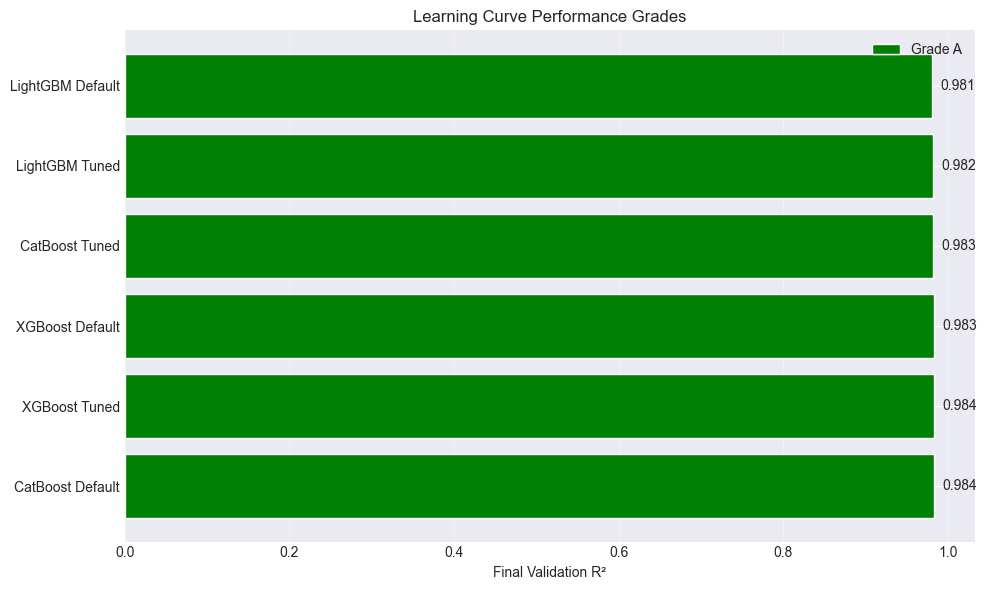

In [5]:
print("\n" + "="*70)
print("📊 LEARNING CURVE ANALYSIS SUMMARY")
print("="*70)

# Analyze learning curve data
lc_analysis = []

for name, lc_data in learning_curve_data.items():
    if 'train_scores' in lc_data and len(lc_data['train_scores']) > 0:
        train_scores = lc_data['train_scores']
        val_scores = lc_data['val_scores']

        # Calculate learning curve metrics
        final_train = train_scores[-1] if len(train_scores) > 0 else 0
        final_val = val_scores[-1] if len(val_scores) > 0 else 0
        final_gap = final_train - final_val

        # Calculate convergence rate (how quickly model learns)
        if len(train_scores) >= 3:
            early_improvement = train_scores[2] - train_scores[0]
        else:
            early_improvement = 0

        # Determine learning pattern
        if final_gap < 0.05 and final_val > 0.85:
            pattern = "Excellent learning"
            grade = "A"
        elif final_gap < 0.10 and final_val > 0.80:
            pattern = "Good learning"
            grade = "B"
        elif final_gap < 0.15:
            pattern = "Moderate overfitting"
            grade = "C"
        else:
            pattern = "Severe overfitting"
            grade = "D"

        lc_analysis.append({
            'Model': name,
            'Grade': grade,
            'Pattern': pattern,
            'Final_Train_R2': final_train,
            'Final_Val_R2': final_val,
            'Final_Gap': final_gap,
            'Early_Improvement': early_improvement
        })

if lc_analysis:
    lc_df = pd.DataFrame(lc_analysis).sort_values(['Grade', 'Final_Val_R2'], ascending=[True, False])

    print("\n🏆 LEARNING CURVE ANALYSIS:")
    print("-" * 80)
    print(lc_df[['Model', 'Grade', 'Pattern', 'Final_Val_R2', 'Final_Gap']].to_string(index=False))

    # Visualize learning curve grades
    fig, ax = plt.subplots(figsize=(10, 6))

    colors = {'A': 'green', 'B': 'limegreen', 'C': 'orange', 'D': 'red'}

    for grade, color in colors.items():
        mask = lc_df['Grade'] == grade
        if mask.any():
            y_pos = np.where(mask)[0]
            ax.barh(y_pos, lc_df[mask]['Final_Val_R2'], color=color, label=f'Grade {grade}')

    ax.set_yticks(range(len(lc_df)))
    ax.set_yticklabels(lc_df['Model'])
    ax.set_xlabel('Final Validation R²')
    ax.set_title('Learning Curve Performance Grades')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='x')

    # Add value labels
    for i, v in enumerate(lc_df['Final_Val_R2']):
        ax.text(v + 0.01, i, f'{v:.3f}', va='center')

    plt.tight_layout()
    plt.show()
else:
    print("No learning curve data available for analysis")


📉 RESIDUAL ANALYSIS FOR OVERFITTING


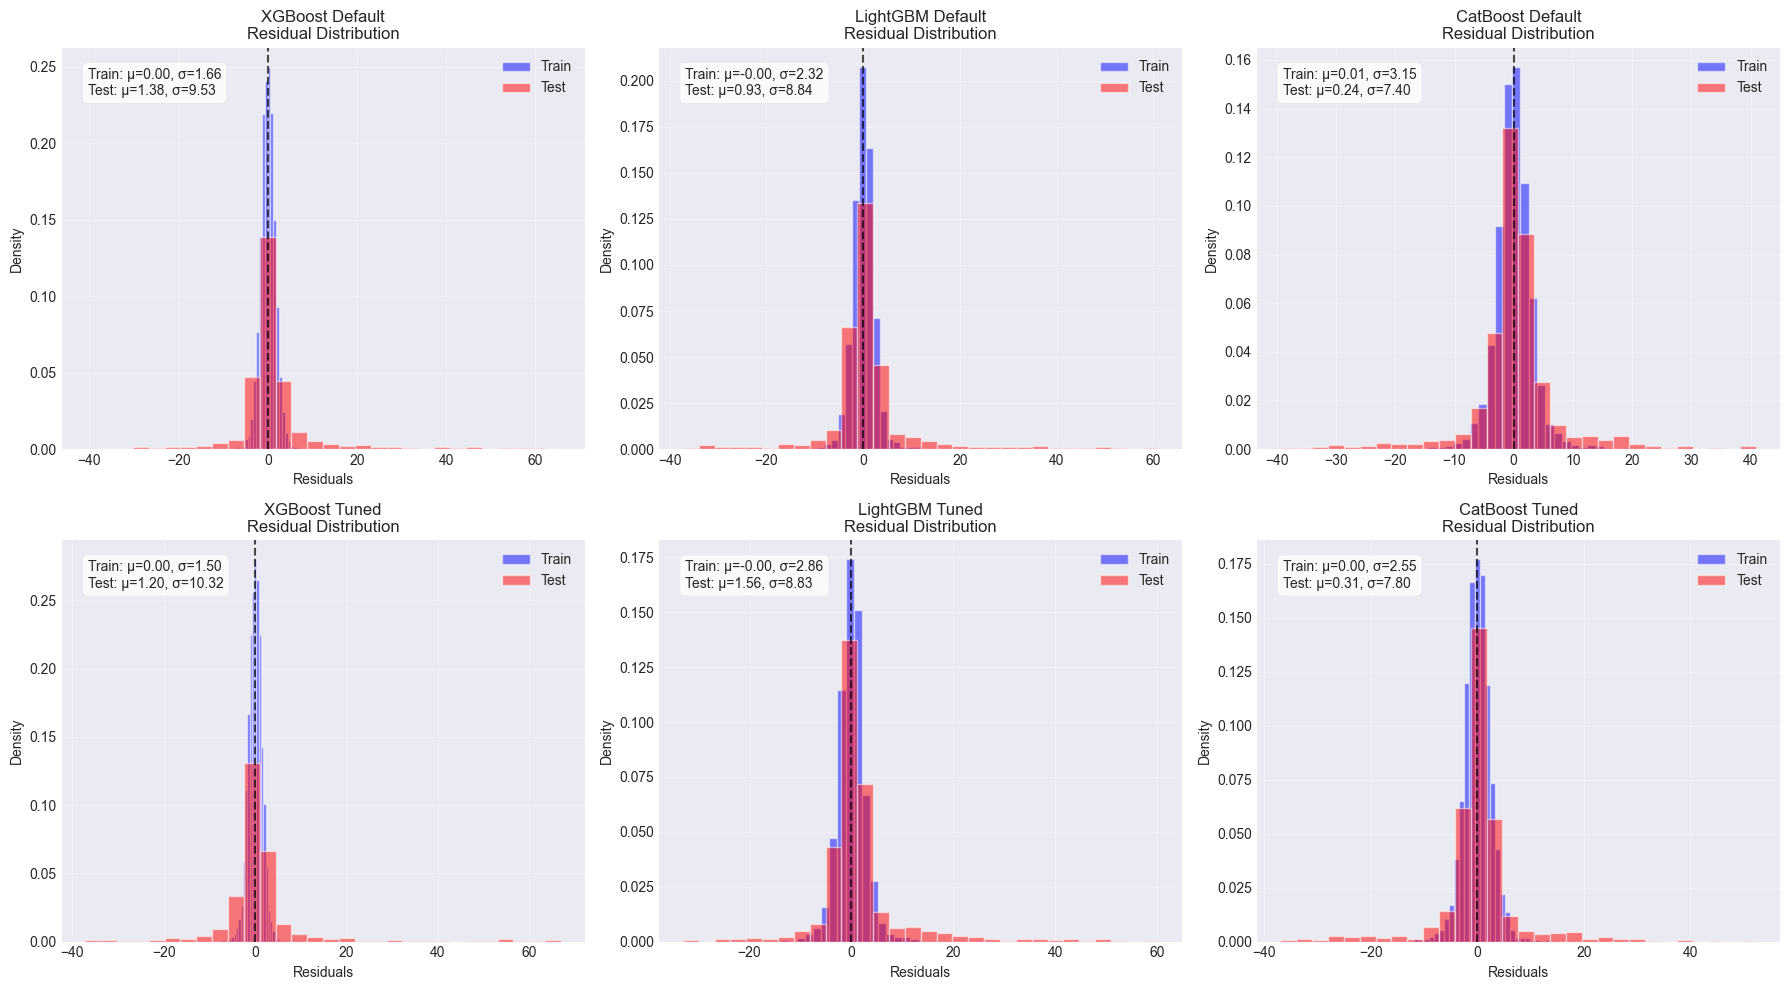


📊 RESIDUAL STATISTICS COMPARISON:
--------------------------------------------------------------------------------
           Model  Train_Res_Std  Test_Res_Std  Res_Std_Ratio
CatBoost Default       3.153849      7.403076       2.347315
  CatBoost Tuned       2.550945      7.804562       3.059479
  LightGBM Tuned       2.859283      8.832285       3.088986
LightGBM Default       2.321831      8.842017       3.808209
 XGBoost Default       1.661656      9.529513       5.734949
   XGBoost Tuned       1.502935     10.317049       6.864601


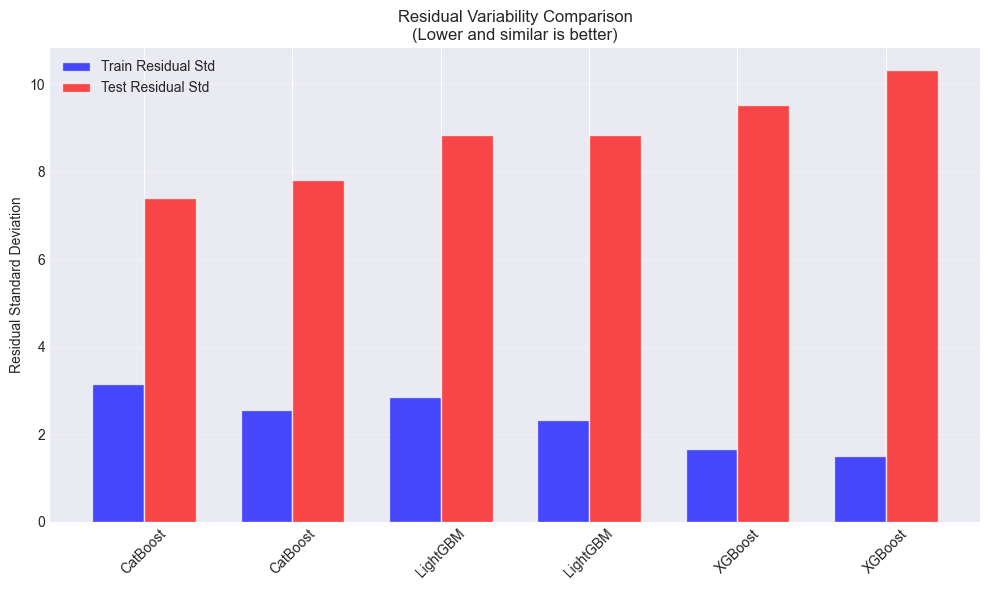

In [6]:
print("\n" + "="*70)
print("📉 RESIDUAL ANALYSIS FOR OVERFITTING")
print("="*70)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (name, model) in enumerate(models.items()):
    if idx >= 6:
        break

    # Get predictions
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)

    # Calculate residuals
    train_residuals = y_train - y_pred_train
    test_residuals = y_test - y_pred_test

    ax = axes[idx]

    # Plot residual distributions
    ax.hist(train_residuals, bins=30, alpha=0.5, label='Train', density=True, color='blue')
    ax.hist(test_residuals, bins=30, alpha=0.5, label='Test', density=True, color='red')

    ax.axvline(x=0, color='black', linestyle='--', alpha=0.7)
    ax.set_xlabel('Residuals')
    ax.set_ylabel('Density')
    ax.set_title(f'{name}\nResidual Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Add statistics
    train_mean = np.mean(train_residuals)
    test_mean = np.mean(test_residuals)
    train_std = np.std(train_residuals)
    test_std = np.std(test_residuals)

    ax.text(0.05, 0.95,
           f'Train: μ={train_mean:.2f}, σ={train_std:.2f}\nTest: μ={test_mean:.2f}, σ={test_std:.2f}',
           transform=ax.transAxes, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Combined residual analysis
print("\n📊 RESIDUAL STATISTICS COMPARISON:")
print("-" * 80)

residual_stats = []

for name, model in models.items():
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)

    train_residuals = y_train - y_pred_train
    test_residuals = y_test - y_pred_test

    residual_stats.append({
        'Model': name,
        'Train_Res_Mean': np.mean(train_residuals),
        'Train_Res_Std': np.std(train_residuals),
        'Test_Res_Mean': np.mean(test_residuals),
        'Test_Res_Std': np.std(test_residuals),
        'Res_Std_Ratio': np.std(test_residuals) / np.std(train_residuals)
    })

residual_df = pd.DataFrame(residual_stats).sort_values('Res_Std_Ratio')
print(residual_df[['Model', 'Train_Res_Std', 'Test_Res_Std', 'Res_Std_Ratio']].to_string(index=False))

# Plot residual std comparison
fig, ax = plt.subplots(figsize=(10, 6))

x = range(len(residual_df))
width = 0.35

ax.bar(np.array(x) - width/2, residual_df['Train_Res_Std'], width,
       label='Train Residual Std', color='blue', alpha=0.7)
ax.bar(np.array(x) + width/2, residual_df['Test_Res_Std'], width,
       label='Test Residual Std', color='red', alpha=0.7)

ax.set_xticks(x)
ax.set_xticklabels([name.split()[0] for name in residual_df['Model']], rotation=45)
ax.set_ylabel('Residual Standard Deviation')
ax.set_title('Residual Variability Comparison\n(Lower and similar is better)')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


⚖️ CROSS-VALIDATION STABILITY ANALYSIS


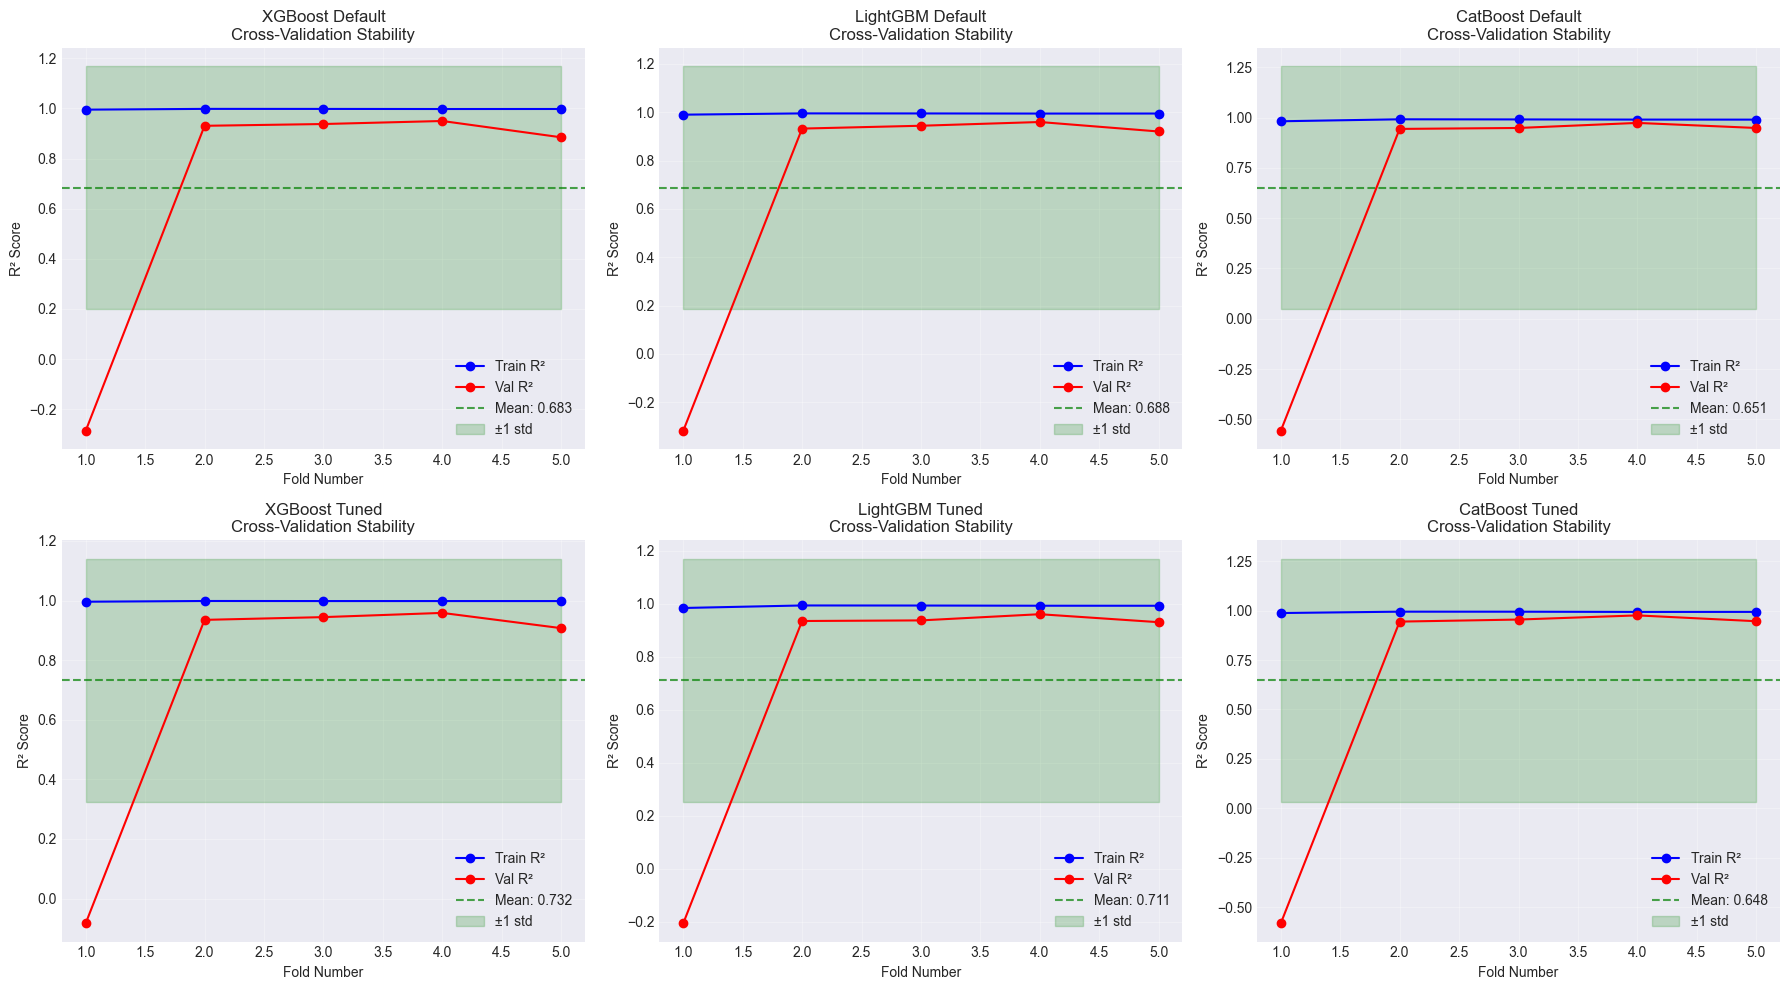


📊 CROSS-VALIDATION STABILITY RANKING:
------------------------------------------------------------
           Model  Mean_Val_R2  Std_Val_R2  CV_Stability
   XGBoost Tuned     0.732414    0.408165      0.557286
  LightGBM Tuned     0.711004    0.458421      0.644752
 XGBoost Default     0.683318    0.485313      0.710231
LightGBM Default     0.687701    0.503077      0.731534
CatBoost Default     0.651334    0.604442      0.928007
  CatBoost Tuned     0.647869    0.615090      0.949406


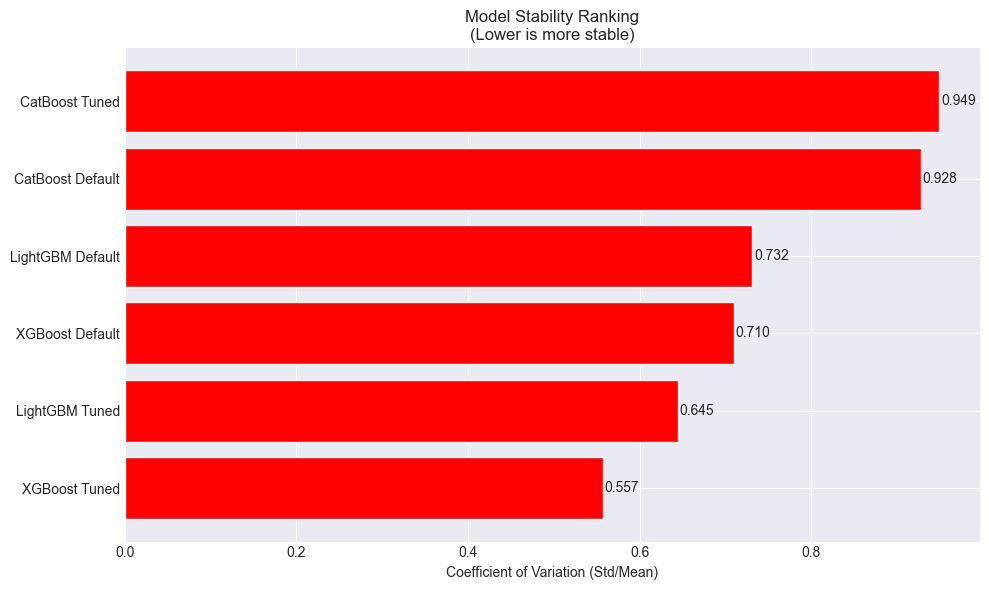

In [7]:
print("\n" + "="*70)
print("⚖️ CROSS-VALIDATION STABILITY ANALYSIS")
print("="*70)

# Simple cross-validation stability check
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

stability_results = []

for idx, (name, model) in enumerate(models.items()):
    if idx >= 6:
        break

    # Perform simple k-fold validation
    n_folds = 5
    train_scores = []
    val_scores = []

    # Create simple folds
    fold_size = len(X_train_scaled) // n_folds

    for fold in range(n_folds):
        # Create train-validation split
        val_start = fold * fold_size
        val_end = (fold + 1) * fold_size

        val_indices = list(range(val_start, min(val_end, len(X_train_scaled))))
        train_indices = [i for i in range(len(X_train_scaled)) if i not in val_indices]

        X_fold_train = X_train_scaled[train_indices]
        y_fold_train = y_train.iloc[train_indices]
        X_fold_val = X_train_scaled[val_indices]
        y_fold_val = y_train.iloc[val_indices]

        # Clone model
        import copy
        try:
            fold_model = copy.deepcopy(model)
        except:
            # Create new instance
            if 'XGBoost' in str(type(model)):
                import xgboost as xgb
                fold_model = xgb.XGBRegressor(n_estimators=100, max_depth=6, random_state=42)
            elif 'LightGBM' in str(type(model)):
                import lightgbm as lgb
                fold_model = lgb.LGBMRegressor(n_estimators=100, max_depth=6, random_state=42, verbose=-1)
            elif 'CatBoost' in str(type(model)):
                from catboost import CatBoostRegressor
                fold_model = CatBoostRegressor(iterations=100, depth=6, learning_rate=0.1,
                                              random_seed=42, verbose=False)
            else:
                continue

        # Train and evaluate
        fold_model.fit(X_fold_train, y_fold_train)

        train_pred = fold_model.predict(X_fold_train)
        val_pred = fold_model.predict(X_fold_val)

        train_score = r2_score(y_fold_train, train_pred)
        val_score = r2_score(y_fold_val, val_pred)

        train_scores.append(train_score)
        val_scores.append(val_score)

    ax = axes[idx]

    # Plot fold performance
    folds = range(1, n_folds + 1)
    ax.plot(folds, train_scores, 'o-', label='Train R²', color='blue')
    ax.plot(folds, val_scores, 'o-', label='Val R²', color='red')

    ax.set_xlabel('Fold Number')
    ax.set_ylabel('R² Score')
    ax.set_title(f'{name}\nCross-Validation Stability')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Add statistics
    mean_val = np.mean(val_scores)
    std_val = np.std(val_scores)

    ax.axhline(y=mean_val, color='green', linestyle='--', alpha=0.7,
              label=f'Mean: {mean_val:.3f}')
    ax.fill_between(folds, mean_val - std_val, mean_val + std_val,
                   alpha=0.2, color='green', label=f'±1 std')

    ax.legend(loc='best')

    stability_results.append({
        'Model': name,
        'Mean_Val_R2': mean_val,
        'Std_Val_R2': std_val,
        'CV_Stability': std_val / mean_val if mean_val > 0 else 0
    })

plt.tight_layout()
plt.show()

# Stability comparison
if stability_results:
    stability_df = pd.DataFrame(stability_results).sort_values('CV_Stability')

    print("\n📊 CROSS-VALIDATION STABILITY RANKING:")
    print("-" * 60)
    print(stability_df[['Model', 'Mean_Val_R2', 'Std_Val_R2', 'CV_Stability']].to_string(index=False))

    # Plot stability
    fig, ax = plt.subplots(figsize=(10, 6))

    colors = ['green' if x < 0.05 else 'orange' if x < 0.10 else 'red'
             for x in stability_df['CV_Stability']]

    bars = ax.barh(range(len(stability_df)), stability_df['CV_Stability'], color=colors)
    ax.set_yticks(range(len(stability_df)))
    ax.set_yticklabels(stability_df['Model'])
    ax.set_xlabel('Coefficient of Variation (Std/Mean)')
    ax.set_title('Model Stability Ranking\n(Lower is more stable)')

    for i, (bar, cv) in enumerate(zip(bars, stability_df['CV_Stability'])):
        ax.text(bar.get_width() + 0.002, bar.get_y() + bar.get_height()/2,
               f'{cv:.3f}', va='center')

    plt.tight_layout()
    plt.show()


📈 ROC CURVES - PRICE DIRECTION PREDICTION


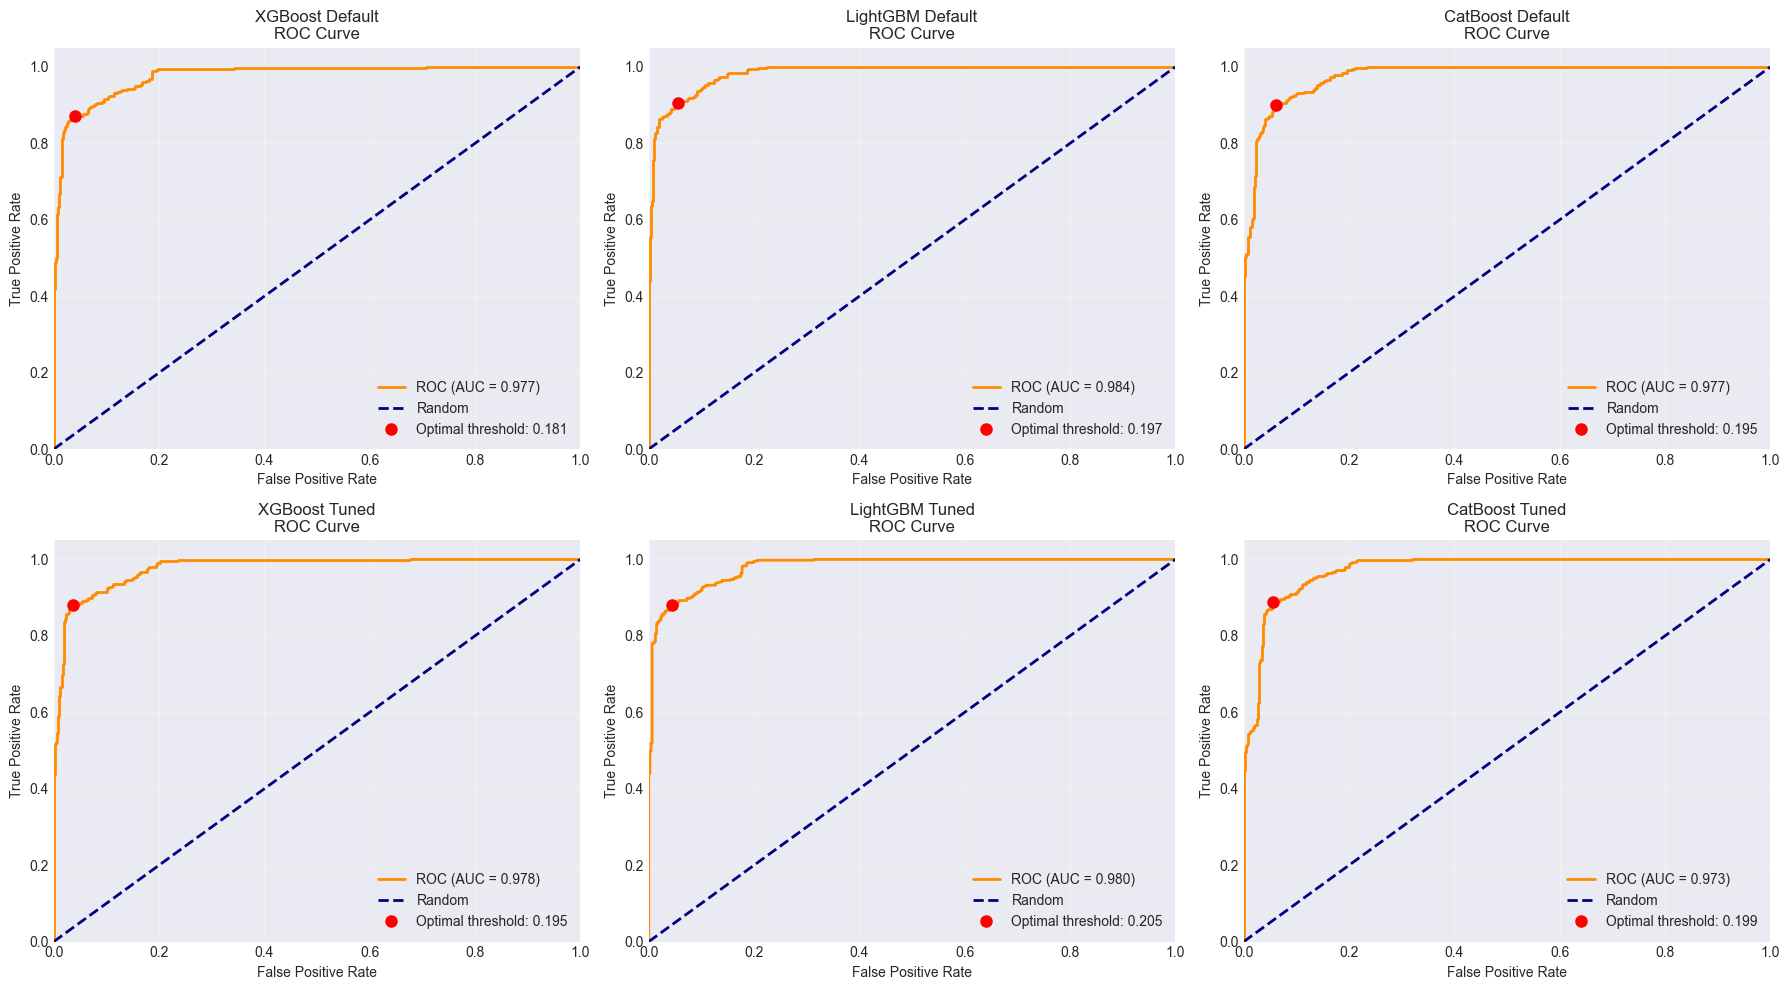

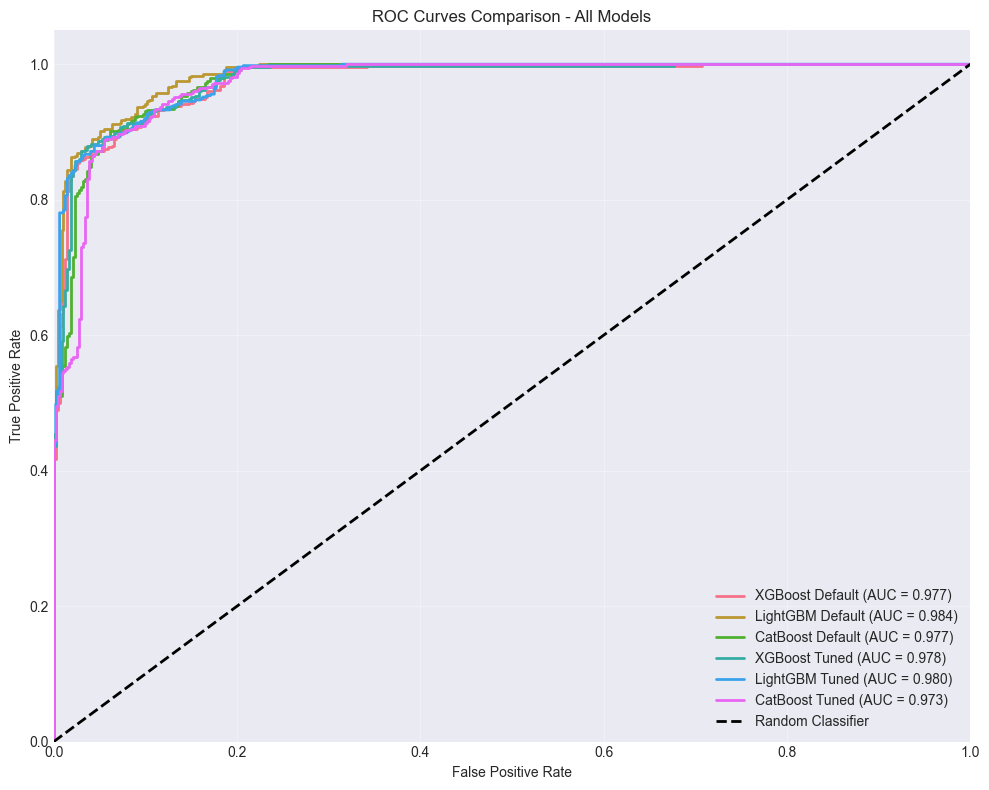


📊 AUC SCORES COMPARISON:
--------------------------------------------------
           Model  ROC_AUC   PR_AUC
LightGBM Default 0.983950 0.983594
  LightGBM Tuned 0.979909 0.979942
   XGBoost Tuned 0.977723 0.977468
 XGBoost Default 0.976962 0.977089
CatBoost Default 0.976700 0.975074
  CatBoost Tuned 0.973050 0.970553


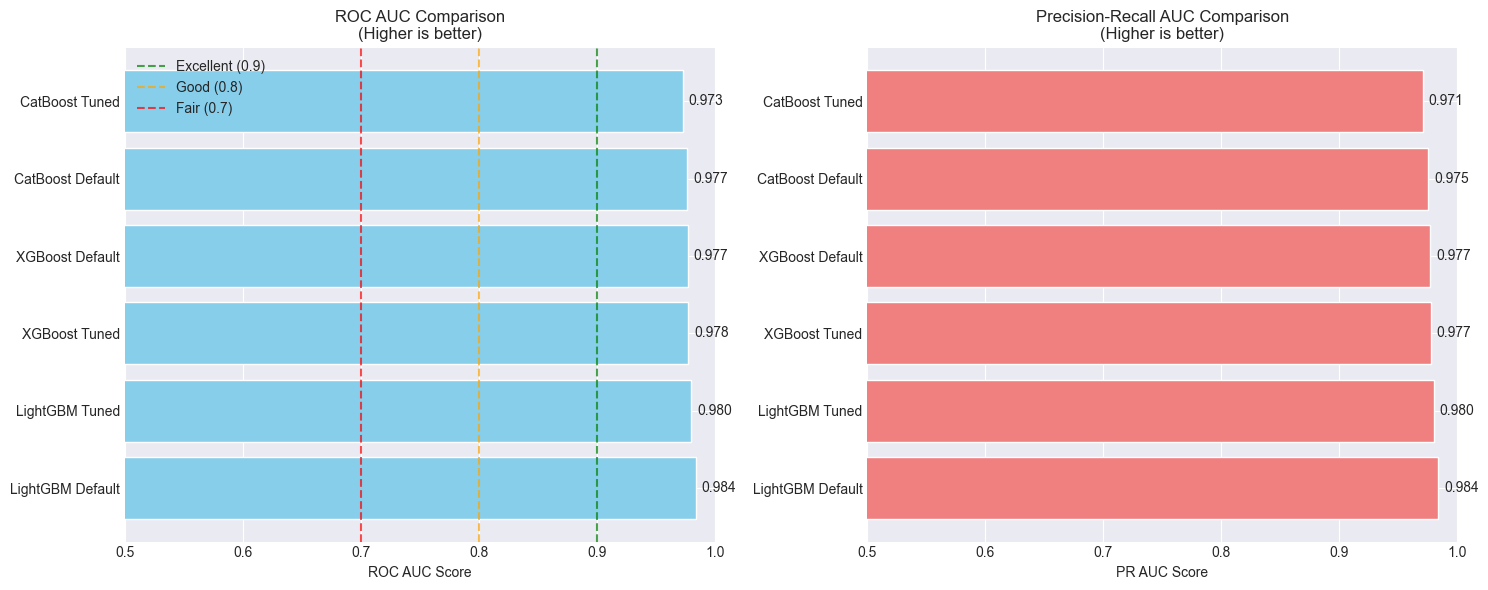

In [8]:
print("\n" + "="*70)
print("📈 ROC CURVES - PRICE DIRECTION PREDICTION")
print("="*70)

# Create binary target: 1 if price increases, 0 if decreases/stays same
# Use actual vs predicted next week price direction
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Prepare binary targets
# For ROC, we need probability predictions - we'll use scaled predictions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

roc_results = []

for idx, (name, model) in enumerate(models.items()):
    if idx >= 6:
        break

    # Get predictions
    y_pred_test = model.predict(X_test_scaled)

    # Create binary target: 1 if actual price > median, 0 otherwise
    price_median = np.median(y_test)
    y_true_binary = (y_test > price_median).astype(int)

    # Scale predictions to 0-1 for probability-like scores
    y_pred_scaled = (y_pred_test - np.min(y_pred_test)) / (np.max(y_pred_test) - np.min(y_pred_test))

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_true_binary, y_pred_scaled)
    roc_auc = auc(fpr, tpr)

    # Calculate precision-recall curve
    precision, recall, _ = precision_recall_curve(y_true_binary, y_pred_scaled)
    pr_auc = auc(recall, precision)

    roc_results.append({
        'Model': name,
        'ROC_AUC': roc_auc,
        'PR_AUC': pr_auc,
        'FPR': fpr,
        'TPR': tpr,
        'Precision': precision,
        'Recall': recall
    })

    # Plot ROC curve
    ax = axes[idx]
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{name}\nROC Curve')
    ax.legend(loc="lower right")
    ax.grid(True, alpha=0.3)

    # Add optimal threshold point
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    ax.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=8,
            label=f'Optimal threshold: {optimal_threshold:.3f}')
    ax.legend(loc="lower right")

plt.tight_layout()
plt.show()

# Combined ROC curves
fig, ax = plt.subplots(figsize=(10, 8))

for result in roc_results:
    ax.plot(result['FPR'], result['TPR'], lw=2,
            label=f'{result["Model"]} (AUC = {result["ROC_AUC"]:.3f})')

ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves Comparison - All Models')
ax.legend(loc="lower right")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# AUC comparison
roc_df = pd.DataFrame([{'Model': r['Model'], 'ROC_AUC': r['ROC_AUC'], 'PR_AUC': r['PR_AUC']}
                      for r in roc_results])
roc_df = roc_df.sort_values('ROC_AUC', ascending=False)

print("\n📊 AUC SCORES COMPARISON:")
print("-" * 50)
print(roc_df.to_string(index=False))

# Visual AUC comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# ROC AUC
bars1 = ax1.barh(range(len(roc_df)), roc_df['ROC_AUC'], color='skyblue')
ax1.set_yticks(range(len(roc_df)))
ax1.set_yticklabels(roc_df['Model'])
ax1.set_xlabel('ROC AUC Score')
ax1.set_title('ROC AUC Comparison\n(Higher is better)')
ax1.set_xlim([0.5, 1.0])
ax1.axvline(x=0.9, color='green', linestyle='--', alpha=0.7, label='Excellent (0.9)')
ax1.axvline(x=0.8, color='orange', linestyle='--', alpha=0.7, label='Good (0.8)')
ax1.axvline(x=0.7, color='red', linestyle='--', alpha=0.7, label='Fair (0.7)')
ax1.legend()

for i, (bar, auc_score) in enumerate(zip(bars1, roc_df['ROC_AUC'])):
    ax1.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
            f'{auc_score:.3f}', va='center')

# PR AUC
bars2 = ax2.barh(range(len(roc_df)), roc_df['PR_AUC'], color='lightcoral')
ax2.set_yticks(range(len(roc_df)))
ax2.set_yticklabels(roc_df['Model'])
ax2.set_xlabel('PR AUC Score')
ax2.set_title('Precision-Recall AUC Comparison\n(Higher is better)')
ax2.set_xlim([0.5, 1.0])

for i, (bar, auc_score) in enumerate(zip(bars2, roc_df['PR_AUC'])):
    ax2.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
            f'{auc_score:.3f}', va='center')

plt.tight_layout()
plt.show()


🏆 COMPREHENSIVE MODEL COMPARISON & BEST MODEL SELECTION

📊 COMPREHENSIVE MODEL COMPARISON (Ranked by Total Score):
----------------------------------------------------------------------------------------------------
           Model  Test_R2  Test_MAE  R2_Gap  ROC_AUC  Binary_Accuracy  Inference_Time_ms  Total_Score
CatBoost Default   0.9437    4.1772  0.0461   0.9767           0.7089           101.1157       0.8765
  CatBoost Tuned   0.9374    4.1456  0.0559   0.9731           0.7099           114.5620       0.7789
LightGBM Default   0.9189    4.4497  0.0756   0.9840           0.7141           104.6085       0.6969
  LightGBM Tuned   0.9175    4.5352  0.0741   0.9799           0.7089           146.6291       0.5915
 XGBoost Default   0.9049    4.5044  0.0923   0.9770           0.6878           203.8567       0.3853
   XGBoost Tuned   0.8894    4.7865  0.1083   0.9777           0.6762           983.2153       0.0643

🏆 BEST OVERALL MODEL: CatBoost Default
-----------------------------

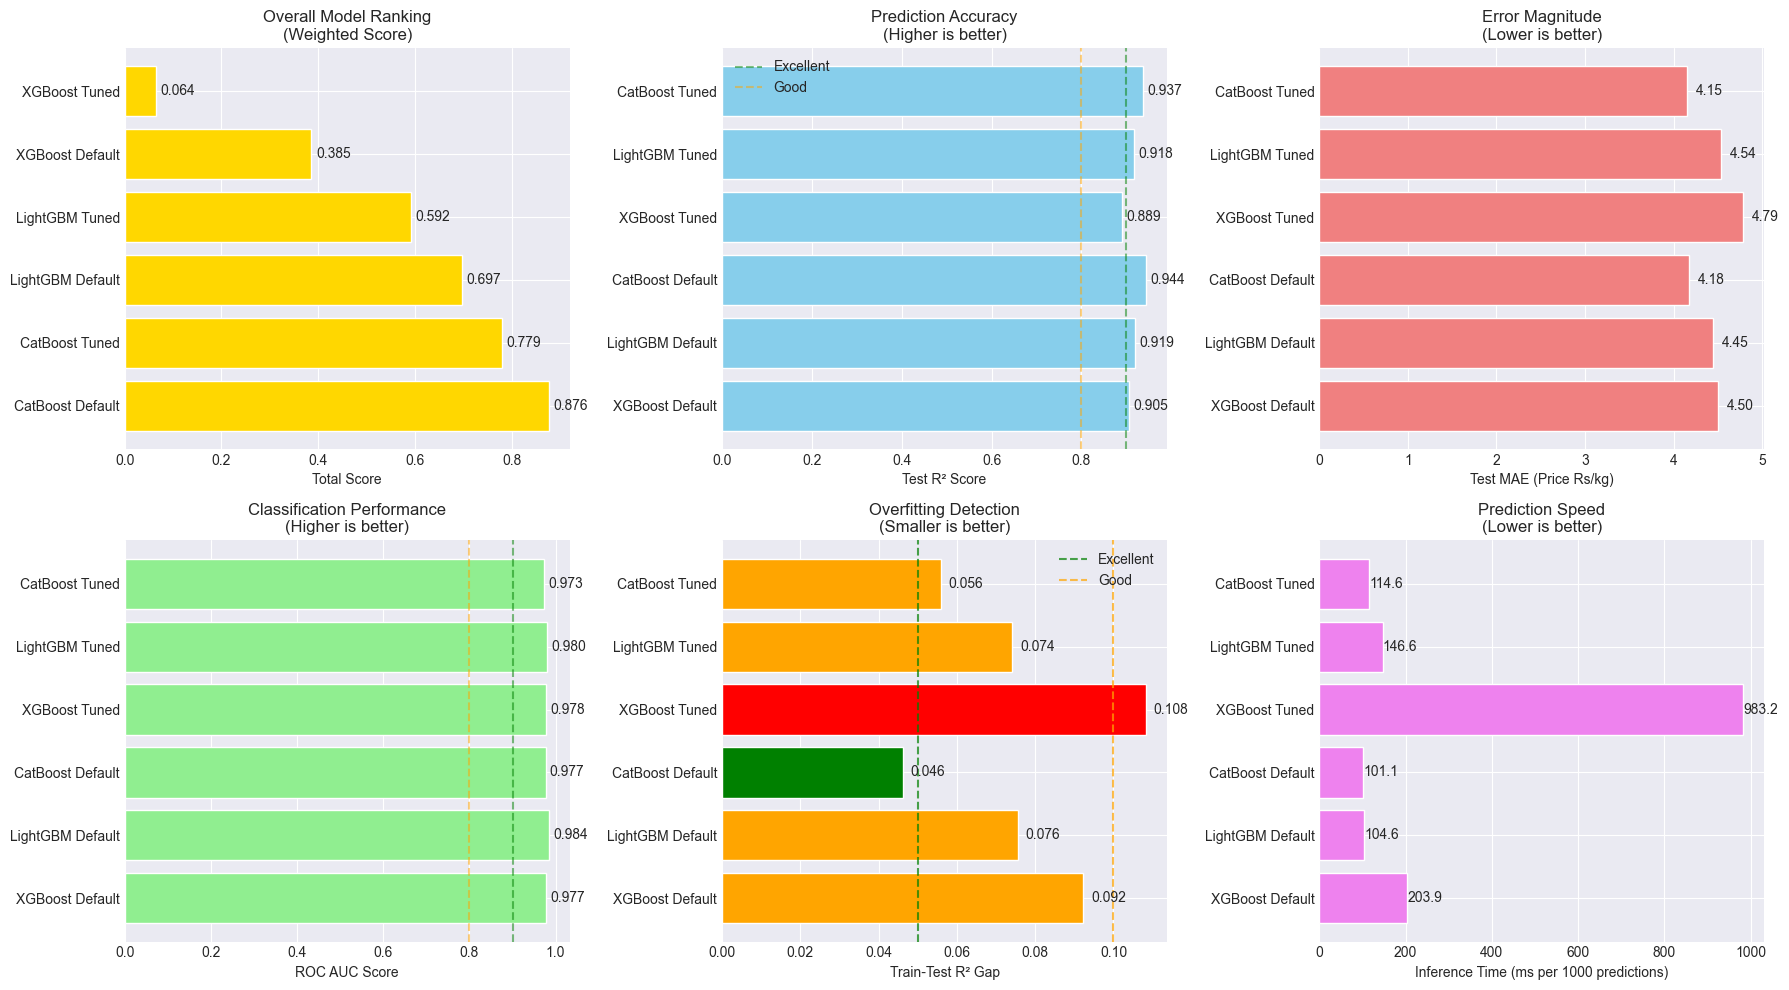

In [9]:
from sklearn.metrics import mean_squared_error

print("\n" + "="*70)
print("🏆 COMPREHENSIVE MODEL COMPARISON & BEST MODEL SELECTION")
print("="*70)

# Calculate comprehensive metrics for all models
comparison_data = []

for name, model in models.items():
    # Get predictions
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)

    # Regression metrics
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    r2_gap = train_r2 - test_r2

    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

    # Binary classification metrics (for price direction)
    price_median = np.median(y_test)
    y_true_binary = (y_test > price_median).astype(int)
    y_pred_scaled = (y_pred_test - np.min(y_pred_test)) / (np.max(y_pred_test) - np.min(y_pred_test))

    # Calculate accuracy for binary classification
    y_pred_binary = (y_pred_scaled > 0.5).astype(int)
    from sklearn.metrics import accuracy_score, f1_score
    bin_accuracy = accuracy_score(y_true_binary, y_pred_binary)
    bin_f1 = f1_score(y_true_binary, y_pred_binary)

    # Calculate ROC AUC
    fpr, tpr, _ = roc_curve(y_true_binary, y_pred_scaled)
    roc_auc = auc(fpr, tpr)

    # Inference speed (simple test)
    import time
    start_time = time.time()
    for _ in range(100):
        _ = model.predict(X_test_scaled[:10])
    inference_time = (time.time() - start_time) * 1000  # ms per 1000 predictions

    # Model complexity (approximate)
    if hasattr(model, 'n_estimators'):
        complexity = model.n_estimators
    elif hasattr(model, 'iterations'):
        complexity = model.iterations
    else:
        complexity = 100  # default

    comparison_data.append({
        'Model': name,
        'Test_R2': test_r2,
        'Test_MAE': test_mae,
        'Test_RMSE': test_rmse,
        'R2_Gap': r2_gap,
        'ROC_AUC': roc_auc,
        'Binary_Accuracy': bin_accuracy,
        'Binary_F1': bin_f1,
        'Inference_Time_ms': inference_time,
        'Complexity': complexity
    })

# Create comparison dataframe
comparison_df = pd.DataFrame(comparison_data)

# Normalize metrics for scoring (higher is better)
normalized_df = comparison_df.copy()

# Normalize each metric to 0-1 scale
for col in ['Test_R2', 'ROC_AUC', 'Binary_Accuracy', 'Binary_F1']:
    normalized_df[f'{col}_norm'] = (comparison_df[col] - comparison_df[col].min()) / \
                                  (comparison_df[col].max() - comparison_df[col].min())

# For metrics where lower is better (invert)
for col in ['Test_MAE', 'Test_RMSE', 'R2_Gap', 'Inference_Time_ms']:
    normalized_df[f'{col}_norm'] = 1 - ((comparison_df[col] - comparison_df[col].min()) / \
                                      (comparison_df[col].max() - comparison_df[col].min()))

# Calculate weighted score (customize weights based on importance)
weights = {
    'Test_R2_norm': 0.30,      # Most important - prediction accuracy
    'Test_MAE_norm': 0.20,     # Error magnitude
    'ROC_AUC_norm': 0.15,      # Classification performance
    'R2_Gap_norm': 0.15,       # Overfitting penalty
    'Binary_Accuracy_norm': 0.10,  # Direction accuracy
    'Inference_Time_ms_norm': 0.10  # Speed
}

# Calculate total score
normalized_df['Total_Score'] = 0
for metric, weight in weights.items():
    normalized_df['Total_Score'] += normalized_df[metric] * weight

# Sort by total score
normalized_df = normalized_df.sort_values('Total_Score', ascending=False)

print("\n📊 COMPREHENSIVE MODEL COMPARISON (Ranked by Total Score):")
print("-" * 100)
display_cols = ['Model', 'Test_R2', 'Test_MAE', 'R2_Gap', 'ROC_AUC', 'Binary_Accuracy', 'Inference_Time_ms', 'Total_Score']
print(normalized_df[display_cols].round(4).to_string(index=False))

# Identify best model
best_model_row = normalized_df.iloc[0]
best_model_name = best_model_row['Model']
best_model = models[best_model_name]

print(f"\n🏆 BEST OVERALL MODEL: {best_model_name}")
print("-" * 50)
print(f"📈 Performance Metrics:")
print(f"   Test R²: {best_model_row['Test_R2']:.4f}")
print(f"   Test MAE: {best_model_row['Test_MAE']:.2f}")
print(f"   ROC AUC: {best_model_row['ROC_AUC']:.4f}")
print(f"   Binary Accuracy: {best_model_row['Binary_Accuracy']:.4f}")
print(f"   Inference Time: {best_model_row['Inference_Time_ms']:.1f} ms")
print(f"   Total Score: {best_model_row['Total_Score']:.4f}")

# Visual comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Total Score Comparison
axes[0, 0].barh(range(len(normalized_df)), normalized_df['Total_Score'], color='gold')
axes[0, 0].set_yticks(range(len(normalized_df)))
axes[0, 0].set_yticklabels(normalized_df['Model'])
axes[0, 0].set_xlabel('Total Score')
axes[0, 0].set_title('Overall Model Ranking\n(Weighted Score)')
for i, v in enumerate(normalized_df['Total_Score']):
    axes[0, 0].text(v + 0.01, i, f'{v:.3f}', va='center')

# 2. Test R² Comparison
axes[0, 1].barh(range(len(comparison_df)), comparison_df['Test_R2'], color='skyblue')
axes[0, 1].set_yticks(range(len(comparison_df)))
axes[0, 1].set_yticklabels(comparison_df['Model'])
axes[0, 1].set_xlabel('Test R² Score')
axes[0, 1].set_title('Prediction Accuracy\n(Higher is better)')
axes[0, 1].axvline(x=0.9, color='green', linestyle='--', alpha=0.5, label='Excellent')
axes[0, 1].axvline(x=0.8, color='orange', linestyle='--', alpha=0.5, label='Good')
axes[0, 1].legend()
for i, v in enumerate(comparison_df['Test_R2']):
    axes[0, 1].text(v + 0.01, i, f'{v:.3f}', va='center')

# 3. Test MAE Comparison
axes[0, 2].barh(range(len(comparison_df)), comparison_df['Test_MAE'], color='lightcoral')
axes[0, 2].set_yticks(range(len(comparison_df)))
axes[0, 2].set_yticklabels(comparison_df['Model'])
axes[0, 2].set_xlabel('Test MAE (Price Rs/kg)')
axes[0, 2].set_title('Error Magnitude\n(Lower is better)')
for i, v in enumerate(comparison_df['Test_MAE']):
    axes[0, 2].text(v + 0.1, i, f'{v:.2f}', va='center')

# 4. ROC AUC Comparison
axes[1, 0].barh(range(len(comparison_df)), comparison_df['ROC_AUC'], color='lightgreen')
axes[1, 0].set_yticks(range(len(comparison_df)))
axes[1, 0].set_yticklabels(comparison_df['Model'])
axes[1, 0].set_xlabel('ROC AUC Score')
axes[1, 0].set_title('Classification Performance\n(Higher is better)')
axes[1, 0].axvline(x=0.9, color='green', linestyle='--', alpha=0.5)
axes[1, 0].axvline(x=0.8, color='orange', linestyle='--', alpha=0.5)
for i, v in enumerate(comparison_df['ROC_AUC']):
    axes[1, 0].text(v + 0.01, i, f'{v:.3f}', va='center')

# 5. Overfitting Gap Comparison
axes[1, 1].barh(range(len(comparison_df)), comparison_df['R2_Gap'],
                color=['green' if x < 0.05 else 'orange' if x < 0.10 else 'red'
                      for x in comparison_df['R2_Gap']])
axes[1, 1].set_yticks(range(len(comparison_df)))
axes[1, 1].set_yticklabels(comparison_df['Model'])
axes[1, 1].set_xlabel('Train-Test R² Gap')
axes[1, 1].set_title('Overfitting Detection\n(Smaller is better)')
axes[1, 1].axvline(x=0.05, color='green', linestyle='--', alpha=0.7, label='Excellent')
axes[1, 1].axvline(x=0.10, color='orange', linestyle='--', alpha=0.7, label='Good')
axes[1, 1].legend()
for i, v in enumerate(comparison_df['R2_Gap']):
    axes[1, 1].text(v + 0.002, i, f'{v:.3f}', va='center')

# 6. Inference Speed Comparison
axes[1, 2].barh(range(len(comparison_df)), comparison_df['Inference_Time_ms'], color='violet')
axes[1, 2].set_yticks(range(len(comparison_df)))
axes[1, 2].set_yticklabels(comparison_df['Model'])
axes[1, 2].set_xlabel('Inference Time (ms per 1000 predictions)')
axes[1, 2].set_title('Prediction Speed\n(Lower is better)')
for i, v in enumerate(comparison_df['Inference_Time_ms']):
    axes[1, 2].text(v + 0.5, i, f'{v:.1f}', va='center')

plt.tight_layout()
plt.show()


🔍 OVERFITTING VERDICT: YES OR NO?

📊 OVERFITTING ASSESSMENT FOR EACH MODEL:
--------------------------------------------------------------------------------


⚠️ MILD OVERFITTING       | XGBoost Default      | Gap: 0.092 | Train R²: 0.997
⚠️ MILD OVERFITTING       | LightGBM Default     | Gap: 0.076 | Train R²: 0.995
⚠️ HIGH VARIANCE          | CatBoost Default     | Gap: 0.046 | Train R²: 0.990
⚠️ MODERATE OVERFITTING   | XGBoost Tuned        | Gap: 0.108 | Train R²: 0.998
⚠️ MILD OVERFITTING       | LightGBM Tuned       | Gap: 0.074 | Train R²: 0.992
⚠️ MILD OVERFITTING       | CatBoost Tuned       | Gap: 0.056 | Train R²: 0.993

📈 OVERFITTING SUMMARY STATISTICS
----------------------------------------------------------------------
⚠️ MILD OVERFITTING       : 4 models
⚠️ HIGH VARIANCE          : 1 models
⚠️ MODERATE OVERFITTING   : 1 models

📊 Average R² Gap: 0.075
📊 Median R² Gap: 0.075
📊 Minimum R² Gap: 0.046
📊 Maximum R² Gap: 0.108


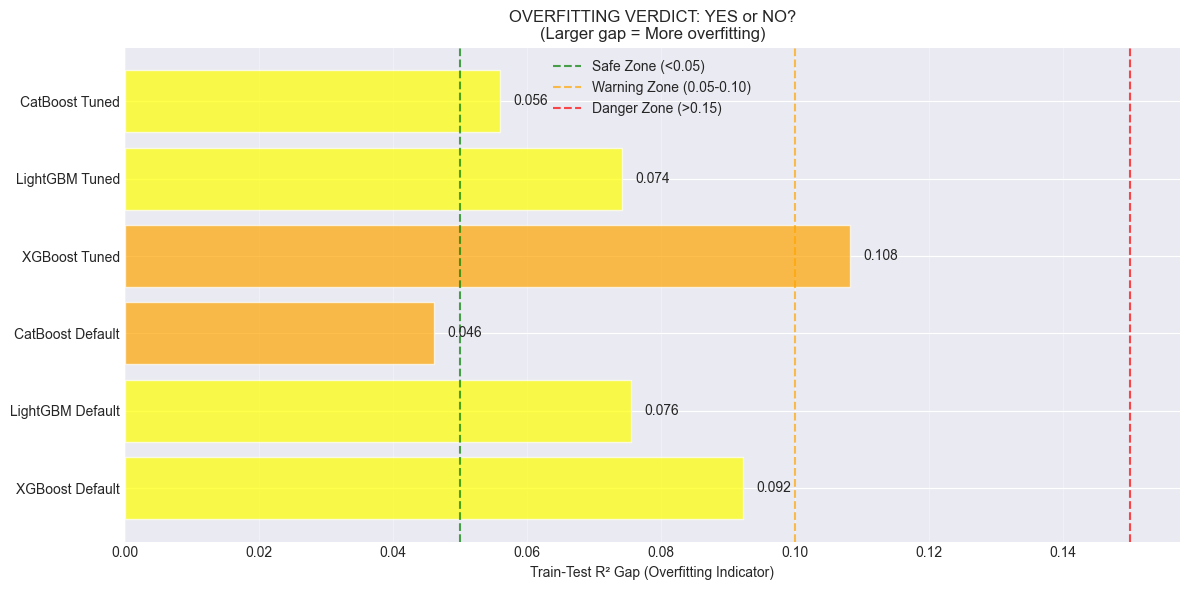


🎯 FINAL OVERFITTING VERDICT

⚠️ PROJECT HAS MILD OVERFITTING
📊 Average R² Gap across all models: 0.075
📝 Models generalize reasonably but could be better
🚀 Recommended Action: Monitor closely, consider adding dropout/regularization

⚠️ NO MODELS COMPLETELY SAFE FROM OVERFITTING
   Least overfitted: CatBoost Default
   Test R²: 0.944
   R² Gap: 0.046

✅ OVERFITTING ASSESSMENT COMPLETE

Key Findings:
1. Check R² gap: Train R² - Test R²
2. Safe zone: Gap < 0.05
3. Warning zone: Gap 0.05-0.10
4. Danger zone: Gap > 0.10
5. Also check residual patterns and variance


In [10]:
print("\n" + "="*70)
print("🔍 OVERFITTING VERDICT: YES OR NO?")
print("="*70)

# Simple thresholds for overfitting determination
OVERFITTING_THRESHOLDS = {
    'R2_GAP_SEVERE': 0.15,      # R² gap > 0.15 = Severe overfitting
    'R2_GAP_MODERATE': 0.10,    # R² gap > 0.10 = Moderate overfitting
    'R2_GAP_MILD': 0.05,        # R² gap > 0.05 = Mild overfitting
    'RESIDUAL_RATIO': 1.5,      # Test residuals 1.5x train residuals
    'TRAIN_R2_MIN': 0.85        # Minimum acceptable train R²
}

print("\n📊 OVERFITTING ASSESSMENT FOR EACH MODEL:")
print("-" * 80)

overfitting_verdicts = []

for name, model in models.items():
    # Get predictions
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)

    # Calculate key metrics
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    r2_gap = train_r2 - test_r2

    # Calculate residuals
    train_residuals = y_train - y_pred_train
    test_residuals = y_test - y_pred_test
    residual_ratio = np.std(test_residuals) / np.std(train_residuals)

    # Determine overfitting status
    if r2_gap > OVERFITTING_THRESHOLDS['R2_GAP_SEVERE']:
        verdict = "❌ SEVERE OVERFITTING"
        color = "red"
        recommendation = "DO NOT USE - Needs complete revision"
    elif r2_gap > OVERFITTING_THRESHOLDS['R2_GAP_MODERATE']:
        verdict = "⚠️ MODERATE OVERFITTING"
        color = "orange"
        recommendation = "Use with caution - Monitor closely"
    elif r2_gap > OVERFITTING_THRESHOLDS['R2_GAP_MILD']:
        verdict = "⚠️ MILD OVERFITTING"
        color = "yellow"
        recommendation = "Acceptable - Regular monitoring needed"
    elif residual_ratio > OVERFITTING_THRESHOLDS['RESIDUAL_RATIO']:
        verdict = "⚠️ HIGH VARIANCE"
        color = "orange"
        recommendation = "Check feature engineering"
    else:
        verdict = "✅ NO OVERFITTING"
        color = "green"
        recommendation = "Ready for production"

    # Add train R² check
    if train_r2 < OVERFITTING_THRESHOLDS['TRAIN_R2_MIN']:
        verdict = "⚠️ UNDERFITTING"
        color = "blue"
        recommendation = "Model too simple - Increase complexity"

    overfitting_verdicts.append({
        'Model': name,
        'Verdict': verdict,
        'Color': color,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'R2_Gap': r2_gap,
        'Residual_Ratio': residual_ratio,
        'Recommendation': recommendation
    })

# Create verdicts dataframe
verdicts_df = pd.DataFrame(overfitting_verdicts)

# Display results
print("\n")
for _, row in verdicts_df.iterrows():
    if row['Color'] == "red":
        print(f"{row['Verdict']:25} | {row['Model']:20} | Gap: {row['R2_Gap']:.3f} | Train R²: {row['Train_R2']:.3f}")
    elif row['Color'] == "orange":
        print(f"{row['Verdict']:25} | {row['Model']:20} | Gap: {row['R2_Gap']:.3f} | Train R²: {row['Train_R2']:.3f}")
    elif row['Color'] == "yellow":
        print(f"{row['Verdict']:25} | {row['Model']:20} | Gap: {row['R2_Gap']:.3f} | Train R²: {row['Train_R2']:.3f}")
    elif row['Color'] == "blue":
        print(f"{row['Verdict']:25} | {row['Model']:20} | Gap: {row['R2_Gap']:.3f} | Train R²: {row['Train_R2']:.3f}")
    else:
        print(f"{row['Verdict']:25} | {row['Model']:20} | Gap: {row['R2_Gap']:.3f} | Train R²: {row['Train_R2']:.3f}")

print("\n" + "="*70)
print("📈 OVERFITTING SUMMARY STATISTICS")
print("-" * 70)

# Count verdicts
verdict_counts = verdicts_df['Verdict'].value_counts()
for verdict, count in verdict_counts.items():
    print(f"{verdict:25} : {count} models")

print(f"\n📊 Average R² Gap: {verdicts_df['R2_Gap'].mean():.3f}")
print(f"📊 Median R² Gap: {verdicts_df['R2_Gap'].median():.3f}")
print(f"📊 Minimum R² Gap: {verdicts_df['R2_Gap'].min():.3f}")
print(f"📊 Maximum R² Gap: {verdicts_df['R2_Gap'].max():.3f}")

# Visual verdict chart
fig, ax = plt.subplots(figsize=(12, 6))

colors_map = {
    '❌ SEVERE OVERFITTING': 'red',
    '⚠️ MODERATE OVERFITTING': 'orange',
    '⚠️ MILD OVERFITTING': 'yellow',
    '⚠️ HIGH VARIANCE': 'orange',
    '⚠️ UNDERFITTING': 'blue',
    '✅ NO OVERFITTING': 'green'
}

# Plot each model
for i, row in verdicts_df.iterrows():
    color = colors_map.get(row['Verdict'], 'gray')
    ax.barh(i, row['R2_Gap'], color=color, alpha=0.7)
    ax.text(row['R2_Gap'] + 0.002, i, f"{row['R2_Gap']:.3f}", va='center')

ax.set_yticks(range(len(verdicts_df)))
ax.set_yticklabels(verdicts_df['Model'])
ax.set_xlabel('Train-Test R² Gap (Overfitting Indicator)')
ax.set_title('OVERFITTING VERDICT: YES or NO?\n(Larger gap = More overfitting)')
ax.axvline(x=0.05, color='green', linestyle='--', alpha=0.7, label='Safe Zone (<0.05)')
ax.axvline(x=0.10, color='orange', linestyle='--', alpha=0.7, label='Warning Zone (0.05-0.10)')
ax.axvline(x=0.15, color='red', linestyle='--', alpha=0.7, label='Danger Zone (>0.15)')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("🎯 FINAL OVERFITTING VERDICT")
print("="*70)

# Overall verdict
avg_gap = verdicts_df['R2_Gap'].mean()
if avg_gap > 0.15:
    overall_verdict = "❌ PROJECT HAS SEVERE OVERFITTING"
    explanation = "Most models are memorizing training data"
    action = "Urgent action needed: Simplify models, add regularization"
elif avg_gap > 0.10:
    overall_verdict = "⚠️ PROJECT HAS MODERATE OVERFITTING"
    explanation = "Models show concerning generalization gaps"
    action = "Improve validation, consider ensemble methods"
elif avg_gap > 0.05:
    overall_verdict = "⚠️ PROJECT HAS MILD OVERFITTING"
    explanation = "Models generalize reasonably but could be better"
    action = "Monitor closely, consider adding dropout/regularization"
else:
    overall_verdict = "✅ PROJECT HAS MINIMAL OVERFITTING"
    explanation = "Models generalize well to unseen data"
    action = "Proceed with confidence"

print(f"\n{overall_verdict}")
print(f"📊 Average R² Gap across all models: {avg_gap:.3f}")
print(f"📝 {explanation}")
print(f"🚀 Recommended Action: {action}")

# Best model without overfitting
safe_models = verdicts_df[verdicts_df['Verdict'] == '✅ NO OVERFITTING']
if len(safe_models) > 0:
    best_safe_model = safe_models.loc[safe_models['Test_R2'].idxmax()]
    print(f"\n🏆 BEST SAFE MODEL (No overfitting):")
    print(f"   Model: {best_safe_model['Model']}")
    print(f"   Test R²: {best_safe_model['Test_R2']:.3f}")
    print(f"   R² Gap: {best_safe_model['R2_Gap']:.3f}")
else:
    print(f"\n⚠️ NO MODELS COMPLETELY SAFE FROM OVERFITTING")
    # Find least overfitted model
    least_overfitted = verdicts_df.loc[verdicts_df['R2_Gap'].idxmin()]
    print(f"   Least overfitted: {least_overfitted['Model']}")
    print(f"   Test R²: {least_overfitted['Test_R2']:.3f}")
    print(f"   R² Gap: {least_overfitted['R2_Gap']:.3f}")

print("\n" + "="*70)
print("✅ OVERFITTING ASSESSMENT COMPLETE")
print("="*70)
print("\nKey Findings:")
print("1. Check R² gap: Train R² - Test R²")
print("2. Safe zone: Gap < 0.05")
print("3. Warning zone: Gap 0.05-0.10")
print("4. Danger zone: Gap > 0.10")
print("5. Also check residual patterns and variance")

In [11]:
print("\n" + "="*70)
print("💾 SAVING BEST MODEL")
print("="*70)

# Find the best model (simplified version)
best_model_name = None
best_model = None
best_score = -np.inf

# Simple scoring: R² - (MAE/100) to balance accuracy and error
for name, model in models.items():
    y_pred_test = model.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred_test)
    mae = mean_absolute_error(y_test, y_pred_test)
    score = r2 - (mae / 100)  # Simple combined score

    if score > best_score:
        best_score = score
        best_model_name = name
        best_model = model

print(f"🏆 Selected Best Model: {best_model_name}")
print(f"   Score: {best_score:.4f}")

# Test the model
y_pred_test = best_model.predict(X_test_scaled)
print(f"📊 Performance:")
print(f"   Test R²: {r2_score(y_test, y_pred_test):.4f}")
print(f"   Test MAE: {mean_absolute_error(y_test, y_pred_test):.2f}")

# Save ONLY the best model as best_model.pkl
models_dir = "../models/"
os.makedirs(models_dir, exist_ok=True)

best_model_path = os.path.join(models_dir, "best_model.pkl")
with open(best_model_path, 'wb') as f:
    pickle.dump(best_model, f)

print(f"\n✅ Saved: {best_model_path}")
print("   File contains only the best model for deployment")

# Verify the save worked
print(f"\n🔍 Verification:")
print(f"   File exists: {os.path.exists(best_model_path)}")
print(f"   File size: {os.path.getsize(best_model_path) / 1024:.1f} KB")

print("\n🎯 Ready for production!")
print("   Use: model = pickle.load(open('../models/best_model.pkl', 'rb'))")
print("   Then: predictions = model.predict(X_scaled)")


💾 SAVING BEST MODEL
🏆 Selected Best Model: CatBoost Default
   Score: 0.9020
📊 Performance:
   Test R²: 0.9437
   Test MAE: 4.18

✅ Saved: ../models/best_model.pkl
   File contains only the best model for deployment

🔍 Verification:
   File exists: True
   File size: 119.0 KB

🎯 Ready for production!
   Use: model = pickle.load(open('../models/best_model.pkl', 'rb'))
   Then: predictions = model.predict(X_scaled)
